# fly_data object : defined in working_functions.py

Things to implement in it :
    -more metadata ?

method the object should have :
    -output the object seen by the fly at a given time based on all the other fly object in the "session" (or just given a number of fly objects)

In [2]:
    ### Necessary modules

#for plots
import matplotlib.pyplot as plt


# trajectorytools needs to be installed. To installed follow the instructions 
# at http://www.github.com/fjhheras/trajectorytools
from trajectorytools.constants import dir_of_data
import trajectorytools as tt
import trajectorytools.plot as ttplot
import trajectorytools.socialcontext as ttsocial
import copy
from scipy import stats
import numpy as np
import cv2
import skvideo.io

from matplotlib.axes import Axes as ax

#My functions
import working_functions as flyD
#import graphing_data #Not useful at the moment

#For importing files and timing cells.
import time
import matplotlib.mlab as mlab

Analysis function based on numerous fly_data objects from a single video :

    -position_summary: summarizes where we can find other flies relatively to our focus fly

    -A focus fly should be defined
    -Relative_fly object should be calculates based on the focus fly
    -What to calculate of this ?
    -Correlation between "turning" of the fly (derivation of orientation) and position of other flies ("global" position and specific position of every fly)

Landscape function ?:
    -Given a focus fly and a set of object, single-object projection of everything the fly sees ? 

Cell below doesn't need to be executed, is just here to write down data so it's possible to pick it up quickly afterward (get_ori takes ~6min to run)

In [2]:
flyD.save_ori_pickle("fly2")
flyD.save_ori_pickle("3flies")
flyD.save_ori_pickle("6flies_1")
flyD.save_ori_pickle("6flies_2")

/home/maubry/python/idtrackerai/working_functions.py:300: RuntimeWarning: divide by zero encountered in true_divide
  angle = np.degrees(np.arctan(np.absolute(y)/np.absolute(x)))
/home/maubry/python/idtrackerai/working_functions.py:300: RuntimeWarning: invalid value encountered in true_divide
  angle = np.degrees(np.arctan(np.absolute(y)/np.absolute(x)))


time elapsed : 2.0min and 18sec
time elapsed : 6.0min and 59sec
time elapsed : 7.0min and 23sec
time elapsed : 7.0min and 40sec


orientations have been corrected only
Correlation is  0.1140938813898623
orientations have been corrected and flipped +90 degrees
Correlation is  0.08689735104389694
[101.59165125 122.18469172 132.87777523 ... 132.96376369 131.51217858
 131.82943639]


/home/maubry/python/idtrackerai/working_functions.py:93: RuntimeWarning: invalid value encountered in less
  angle[angle < 0] += 360
/home/maubry/python/idtrackerai/working_functions.py:96: RuntimeWarning: invalid value encountered in less
  ori_rel[ori_rel < 0] += 360


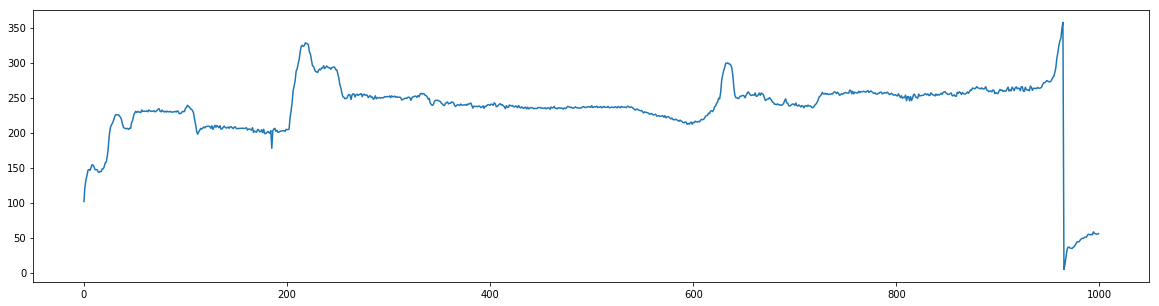

In [6]:
flystack = flyD.get_ori_pickle('6flies_1')

fly = flystack[1]
fly_correc = copy.deepcopy(fly)
fly_correc.ori_correc(overwrite=True)

fly2 = flystack[2]
fly2_correc = copy.deepcopy(fly2)
fly2_correc.ori_correc(overwrite=True)
# #Get first fly and correct its orientations

rel = flyD.relative_fly(fly_correc, fly2_correc)
showrange = range(10000)

plt.figure(figsize=(20,5))
#plt.plot(fly_correc.orientations)
plt.plot(rel.angle[:1000])
print(rel.angle)

/home/maubry/python/idtrackerai/working_functions.py:98: RuntimeWarning: invalid value encountered in less
  angle[angle < 0] += 360
/home/maubry/python/idtrackerai/working_functions.py:300: RuntimeWarning: invalid value encountered in true_divide
  angle = np.degrees(np.arctan(np.absolute(y)/np.absolute(x)))


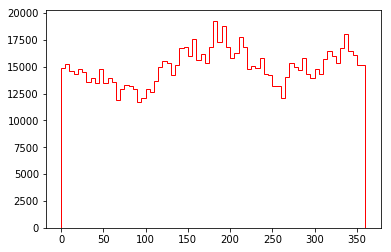

NameError: name 'x_stack' is not defined

In [4]:
tomi = flyD.get_ori_pickle('6flies_2')

hue = flyD.relative_set(tomi)
            
            

dist_stack = hue.dist[~np.isnan(hue.dist)]
angle_stack = hue.orientations[~np.isnan(hue.orientations)]


plt.hist(angle_stack, bins=72, range=[0, 360], histtype='step',edgecolor='r')
# H, bins = np.histogram(angle_stack[:6], bins=72, range=[0, 360])
# H+=np.histogram(angle_stack[6:], bins=72,range=[0,360])[0]

# bincentres = [(bins[i]+bins[i+1])/2. for i in range(len(bins)-1)]
# plt.step(bincentres,H,where='mid',color='b',linestyle='--')

plt.show()



# Define bin edges: (left/bottom limit, right/top limit, bin width)
h_min = np.min([np.nanmin(x_stack)/2, np.nanmin(y_stack)/2])
h_max = np.min([np.nanmax(x_stack)/2, np.nanmax(y_stack)/2])
bin_size = (h_max - h_min)/50
bins = [np.arange(h_min, h_max, bin_size),np.arange(h_min, h_max, bin_size)]

H, xedges, yedges = np.histogram2d(y_stack, x_stack, bins=bins,normed = True)
X, Y = np.meshgrid(xedges, yedges)
fig, ax_meanposmap = plt.subplots(figsize=(19,7))
im = ax_meanposmap.pcolormesh(X, Y, H)
# Add colorbar, labels, etc.
ax_cb = fig.colorbar(im, ax=ax_meanposmap)
ax_meanposmap.set_aspect('equal','box')
ax_meanposmap.set_title('All individuals',fontsize=20);
ax_meanposmap.set_xlabel('Left-Right',fontsize = 20)
ax_meanposmap.set_ylabel('Back-Front',fontsize = 20)
ax_meanposmap.tick_params(labelsize=14)
ax_cb.ax.tick_params(labelsize=24)
ax_cb.set_label('Neighbour density',fontsize=24)


/home/maubry/python/idtrackerai/working_functions.py:96: RuntimeWarning: invalid value encountered in less
  angle[angle < 0] += 360
/home/maubry/python/idtrackerai/working_functions.py:99: RuntimeWarning: invalid value encountered in less
  ori_rel[ori_rel < 0] += 360


orientations have been corrected and flipped +90 degrees
Correlation is  0.08689735104389694
CPU times: user 2.64 s, sys: 95.2 ms, total: 2.74 s
Wall time: 2.92 s


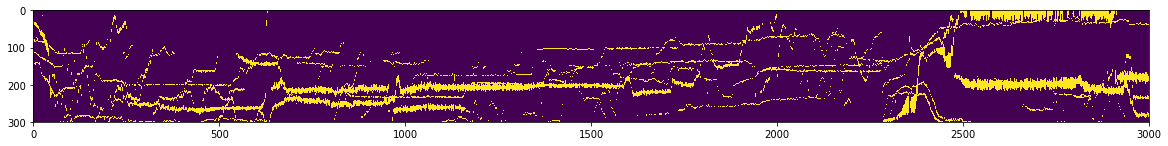

<Figure size 1440x360 with 0 Axes>

In [30]:
%%time

#Defining landscape function.
#For a specific fly, should output what the fly sees as stimilus for every frames.

    #Convert everything into a simple matrix of occupied pixels
    
stack = flyD.get_ori_pickle('6flies_1')
identity = 3
hue = flyD.landscape(stack, identity)


#fig, ax_meanposmap = plt.subplots(figsize=(200,20))
#ax_meanposmap.imshow(X=hue[:1000,])

time_range = range(3000)

hue_trans = np.transpose(hue)
fig, ax_meanposmap = plt.subplots(figsize=(20,200))
ax_meanposmap.imshow(X=hue_trans[...,time_range])
plt.figure(figsize=(20,5))

focusfly = copy.deepcopy(stack[2])
focusfly.orientations = focusfly.ori_correc()

# plt.plot(fly_correc.orientations)
# plt.plot(focusfly.orientations[time_range])
# plt.plot(focusfly.speeds[time_range])


def gifit(vision_lines, downlim, uplim):
    frame_range = range(downlim, uplim)
    vision_matrix = list()
    for line in vision_lines[frame_range,]:
        line_stack = np.stack([line,line])
        for _ in range(3):
            line_stack = np.vstack([line_stack,line_stack])
            
        col_layer1 = np.zeros_like(line_stack)
        col_layer1[line_stack == 1] = 220
        
        col_layer2 = np.zeros_like(line_stack)
        col_layer2[line_stack == 1] = 150
        
        cols = np.stack([line_stack,col_layer1, col_layer2], axis =-1)
        vision_matrix.append(cols)
        
    vision_matrix = np.stack(vision_matrix)
        


#         line_stack = np.transpose(line_stack)
#         fig, ax_meanposmap = plt.subplots(figsize=(32,300))
#         ax_meanposmap.imshow(X=line_stack)
    inputdict={'-r': '30'}
    outputdict={'-vcodec': 'libx264', '-pix_fmt': 'yuv420p', '-r': '30'}
    file_name = "flyvision_fly"+str(identity)+".avi"
    writer = skvideo.io.FFmpegWriter(file_name, inputdict, outputdict)
    n_frames = int(uplim - downlim)
    for i in range(n_frames):
        writer.writeFrame(vision_matrix[i,:,:,:])
    writer.close()
                
gifit(hue, 250, 700)

## Correlation between landscape and behaviour 

We want to find correlations between behaviour at time T (e.g. turning left) to previous landscape (e.g. last 30 frames).
How to avoid correlation betwee past behaviour and current behaviour ? 
    -Need moment when behaviour *begins* to avoid inertia effect.

/home/maubry/python/idtrackerai/working_functions.py:92: RuntimeWarning: invalid value encountered in less
  angle[angle < 0] += 360
/home/maubry/python/idtrackerai/working_functions.py:95: RuntimeWarning: invalid value encountered in less
  ori_rel[ori_rel < 0] += 360
/home/maubry/python/idtrackerai/working_functions.py:299: RuntimeWarning: invalid value encountered in true_divide
  angle = np.degrees(np.arctan(np.absolute(y)/np.absolute(x)))


120.3542200444475
DescribeResult(nobs=1000, minmax=(0.325290501426565, 359.9626395295444), mean=181.43476293596228, variance=10817.809476819904, skewness=0.009266992849251435, kurtosis=-1.1853679611597954)
DescribeResult(nobs=796235, minmax=(0.0, 359.99931889477506), mean=176.57514930648068, variance=10398.567905761545, skewness=0.07196501797851178, kurtosis=-1.1753803759268093)
Ks_2sampResult(statistic=0.26345253106247124, pvalue=3.971255951394018e-61)
Ks_2sampResult(statistic=0.26275068263825685, pvalue=8.35454655222863e-61)


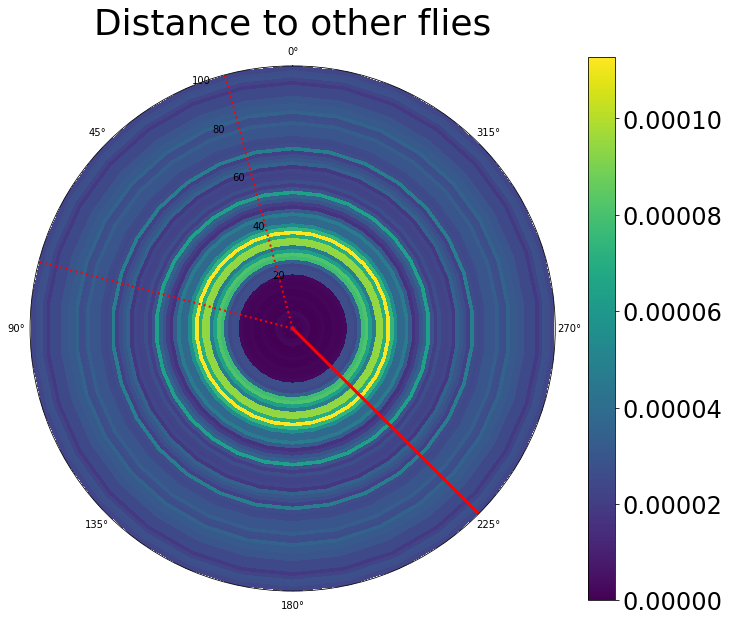

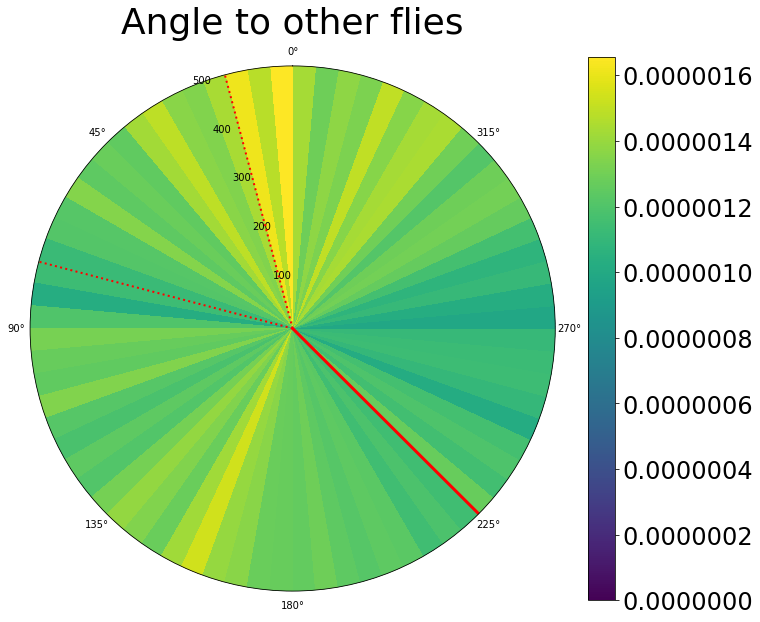

In [7]:
rel_flies = flyD.relative_set(flyD.get_ori_pickle('6flies_2'))

flyD.polar_histogram(rel_flies, dist_range=100)
flyD.polar_histogram(rel_flies,distance=False)
# polar_histogram(get_ori_pickle('6flies_2'), force_bin=10)
# polar_histogram(get_ori_pickle('6flies_2'),distance=False, force_bin=50)


from scipy.stats import ks_2samp


stack = flyD.relative_set(flyD.get_ori_pickle('6flies_1'))
print(stats.circmean(stack.orientations[~np.isnan(stack.orientations)], high=360))

#Creating two uniform datasets of same statistical caracteristics as our angles and distances
rand_angles = np.random.uniform(0,360,1000)
rand_distances = np.random.uniform(30,800,1000)

print(stats.describe(rand_angles))
print(stats.describe(stack.orientations[~np.isnan(stack.orientations)]))

#Testing to see if our angles and distances are randomly distributed or not
print(ks_2samp(rand_angles, stack.orientations))
print(ks_2samp(rand_distances, stack.dist))
#Our data are indeed not uniform.